## Analysis of stock prices using PCA / Notebook 2

In this notebook you will read the file `SP500.csv` that you prepared in notebook 1 into a `Spark` dataframe and then use the code in `lib/spark_PCA.py` to perform PCA on the diff sequences.

We start by starting a spark Context and reading the file into a dataframe.

In [1]:
#import findspark
#findspark.init()
from pyspark import SparkContext

#sc.stop()
sc = SparkContext(master="local[6]",pyFiles=['lib/spark_PCA.py'])

from pyspark.sql import *
sqlContext = SQLContext(sc)

%pylab inline
import sys
sys.path.append('./lib')

import numpy as np
from spark_PCA import computeCov

Populating the interactive namespace from numpy and matplotlib


In [2]:
# read the file in a dataframe.
df=sqlContext.read.csv('data/SP500.csv',header='true',inferSchema='true')
df.count()

13422

In [3]:
columns=df.columns
col=[c for c in columns if '_D' in c]

Extract the tickers from the column names of `df`

In [4]:
#del below
columns=df.columns
col=[c for c in columns if '_D' in c]
tickers=[a[:-2] for a in col]
#del above
tickers[:10],len(tickers)

(['YUM', 'HD', 'NVDA', 'RAI', 'PDCO', 'MSFT', 'EXC', 'GILD', 'UPS', 'ISRG'],
 392)

#### Create an RDD of numpy arrays
In order to use `spark_PCA.py` we need to transform the dataframe into an RDD of numpy vectors.

Write a function `make_array(row)` that takes as input a row of `df` and returns a numpy array (`dtype=np.float64`) that contains the values of the diff rolumns (`_D`). Use `np.nan_to_num` to transform `nan`s into zeros.

Use `map` to create an RDD called `Rows` of numpy arrays.


In [116]:
def make_array(row):
    # return None (del below)
    array=np.array([row[c] for c in col],dtype=np.float64)
    array=np.nan_to_num(array)
    return array
Rows=df.select(col).rdd.map(make_array)

In [117]:
# We are now ready to run ComputeCov to create the covariance matrix.
OUT=computeCov(Rows)
OUT.keys()

dict_keys(['E', 'NE', 'O', 'NO', 'Cov', 'Mean', 'Var'])

In [118]:
def _sum(pair1,pair2):
    x1,n1=pair1
    x2,n2=pair2
    s=np.nansum(np.dstack((x1,x2)),axis=2)
    n=n1+n2
    return s,n
def makepair(x):
    return x,1-np.isnan(x)

x1,x2=Rows.take(2)
p1=makepair(x1)
p2=makepair(x2)
np.nansum(np.dstack((x1,x2)),axis=2)
S,N=Rows.map(makepair).reduce(_sum)
Mean=S/N

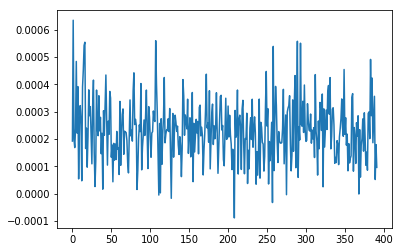

In [119]:
plot(Mean[0,:]);
#ylim([-1000,5000])

In [120]:
zero_Rows=Rows.map(lambda x:x-Mean)

In [121]:
from numpy import linalg as LA
eigval,eigvec=LA.eigh(OUT['Cov'])
eigval=eigval[-1::-1] # reverse order
eigvec=eigvec[:,-1::-1]

In [138]:
inv_eigvec=np.linalg.inv(eigvec)
np.sum((np.dot(eigvec.transpose(),eigvec)-eye(392))**2)

1.995932600508195e-27

In [123]:
rows=zero_Rows.collect()

In [124]:
X=np.stack([r[0,:] for r in rows])
X.shape

(13422, 392)

In [141]:
XX=np.dot(X,eigvec.transpose())
XX.shape,X.shape,eigval.shape
eigval[:5]

array([0.0247295 , 0.00412965, 0.00286062, 0.00250559, 0.00135792])

In [146]:
np.dot(XX[:,2],XX[:,3])

-0.15437048058477193

### Compute percentage-of-variance explained graph
Write code to plot the percentage of variance explained as a function of the number of top eigen-vectors used.

You should get a figure similar to this:

![percent-var-explained](figs/percentageOfVarianceExplained.png)

## SVD and low rank approximations


Consider a data '''X''', with column-wise zero [[empirical mean]] (the sample mean of each column has been shifted to zero), where each of the ''n'' rows represents a different repetition of the experiment, and each of the ''p'' columns gives a particular kind of feature (say, the results from a particular sensor).

PCA is based on a spectral decomposition of the covariance matrix $\Sigma$.
$\Sigma = U S U^T$ Where $U$ is an orthonormal matrix and $S$ is a diagonal matrix. The elements of the diagonal of $S$ are the eigen-values corresponding to the eigen-vectors of $\Sigma$ which are also the variances along the principal directions defined by $\Sigma$.

[**Singular Value Decomposition**](https://en.wikipedia.org/wiki/Singular-value_decomposition) or SVD is more general than Eigen-Decomposition. If $M$ is an $m\times n$ matrix (not necessarily square), then it can be written in the form $M=USV^T$
Where:
* $U$ is an $m \times m$ orthonormal matrix. 
* $S$ is an $m \times n$ matrix in which only the diagonal entries can be non-zero
* $V$ is an $n \times n$ orthonormal matrix.

### Relation to PCA

If $M$ is the covariance matrix, i.e. a symmetric real valued matrix, then $U=V$ and we get the PCA decomposition.

### Singular values and singular vectors

Similarly to the eigen-decomposition, the SVD matrices can be interpreted as eigen-vectors. If we denote by $U_i$ and $V_i$ the $i$'th columns of $U$ and $V$ respectively, and by $s_i$ the $i$-th element of the diagonal of $S$, then $U_i M = s_i V_i$ and $M V_i = s_i U_i$ also


[0.27853651 0.32753682 0.35333024 0.37053218 0.38313828]


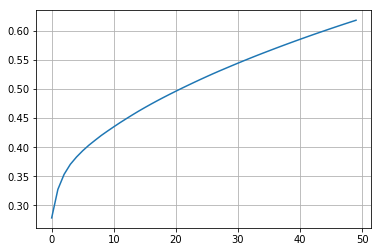

In [8]:
#del cell
cum=cumsum(eigval)
cum=cum/cum[-1]
print(cum[:5])
plot(cum[:50])
grid()

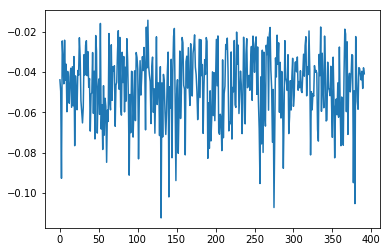

In [9]:
plot(eigvec[:,0])

### Checking your calculations
One good way to check your calculations is to create a scatter-plot projecting the data on two of the largest variance eigen-vectors.

In the directory `figs` you will find scatter plots corresponding to the six combinations of the top 4 eigenvectors.

In these scatter-plots the ticker is replaced by the sector ID.

Stocks from the same sector tend to have similar fluctuations. That is because they have similar sensitivities to costs (labor cost, energy) and profits (income distribution, holiday shopping). For example check out `figs/scatter.2.1.pdf` in which regions that are dominated by Finance, Energy or IT have been marked. 

It is not a requirement, but if you want to reassure yourself that you have done things right, we recommend that you create similar scatter plots and compare with those given. Your scatter-plots will be slightly different, because of the stocks you have eliminated, but spectral analysis is pretty robust, so your scatter plots should be quite similar (remember that the inverse of an eigen-vector is also an eigen-vector, so horizontal or vertical reflections of the scatter plot are meaningless).

In [10]:
!ls data

SP500.csv           spectral.pickle     tickerInfo.tsv
Tickers.pkl         student_tickers.csv tickers.txt


In [11]:
import pickle
Tickers=pickle.load(open('data/Tickers.pkl','br'))
type(Tickers['TickerInfo'])

pandas.core.frame.DataFrame

In [12]:
import pandas as pd

In [13]:
#TickerInfo=pd.read_csv('data/SP500Info.csv')
TickerInfo=Tickers['TickerInfo']
TickerInfo.head()

,Ticker,Name,Sector,SECTOR_ID
0,MMM,3M|3M Company,Industrials,INDS
1,ABT,Abbott Laboratories,Health Care,HC
2,ABBV,AbbVie Inc.,Health Care,HC
3,ACN,Accenture plc,Information Technology,IT
4,ATVI,Activision Blizzard,Information Technology,IT


In [14]:
## Del below until KNN section
# Create a dictionary that maps tickers to sector IDs
NN=TickerInfo[['Ticker','SECTOR_ID']]
Ticker2Sector={ a[1]:a[2] for a in NN.to_records()}
sectors=[]
unknown=known=0
for i in range(len(tickers)):
    ticker=tickers[i]
    if ticker in Ticker2Sector:
        sectors.append(Ticker2Sector[ticker])
        known+=1
    else:
        sectors.append(ticker)
        unknown+=1
        #print('missing category for ',ticker)
print('%d known category, %d unknown category'%(known,unknown))

392 known category, 0 unknown category


In [15]:
# Generate the scatter plot of the stocks on a pair of eigen-vectors defined by i0,i1
def Scatter_Stocks(i0=0,i1=1):
    fig, ax = plt.subplots(figsize=(20,20));  # In order that the stock ticker names are readable we make the plot very large
    plt.xlim([np.amin(eigvec[:,i0]),np.amax(eigvec[:,i0])]);
    plt.ylim([np.amin(eigvec[:,i1]),np.amax(eigvec[:,i1])]);
    plt.title('SP500 stocks scatter on '+str(i0)+', '+str(i1),fontsize=20);
    plt.xlabel('Coeff %d'%i0);
    plt.ylabel('Coeff %d'%i1);
    for i in range(len(tickers)):
        ax.annotate(sectors[i], (eigvec[i,i0],eigvec[i,i1]),fontsize=10);
    # This very large plot is hard to view and manipulate inside the notebook. We therefor export it into a pdf file
    fig.savefig('figs/scatter.'+str(i0)+'.'+str(i1)+'.pdf', format='PDF');
    # After exporting, we clear the figure so that the plot does not appear in the notebook.
    fig.clear();
    return None

In [16]:
for i0 in range(4):
    for i1 in range(i0):
        print(i0,i1)
        Scatter_Stocks(i0,i1);

1 0
2 0
2 1
3 0
3 1
3 2


<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>